In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os

import pickle
from pickle import load

import numpy as np
import tensorflow as tf

from skimage.transform import resize

from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def mostrar_img_blue(img, titulo = ''):
  plt.axis("off")
  plt.suptitle(titulo)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
def mostrar_img(img, titulo = ''):
  plt.axis("off")
  plt.suptitle(titulo)
  plt.imshow(img)
  plt.show()

In [ ]:
def salvar_modelo_treino(caminho, arquivo):
  pickle_data = open(caminho, 'wb')
  pickle.dump(arquivo, pickle_data)
  pickle_data.close()

In [ ]:
def carregar_modelo(caminho):
  modelo = load(open(caminho, 'rb'))
  return modelo

In [ ]:
def carregar_imagens_rotulos(caminho, pastas, tamanho_imagem):
  imagens = []
  rotulos = []

  for rotulo, pasta in enumerate(pastas):
    pasta_imagem = caminho + '/' + pasta
    nome_imagens = os.listdir(pasta_imagem)

    for nome_imagem in nome_imagens:
      caminho_imagem = pasta_imagem + '/' + nome_imagem

      imagem = cv2.imread(caminho_imagem)
      imagem = np.array(imagem, dtype=np.uint8)
      imagem_normalizada = cv2.resize(imagem, tamanho_imagem)

      imagens.append(imagem_normalizada)
      rotulos.append(rotulo)

  imagens = np.array(imagens)
  rotulos = np.array(rotulos)

  return imagens, rotulos

In [ ]:
def treino_split(imagens, rotulos):
  X_treino, X_teste, y_treino, y_teste = train_test_split(imagens, rotulos, test_size=0.2, random_state=42)

  X_treino = X_treino.astype('float32') / 255.0
  X_teste = X_teste.astype('float32') / 255.0

  return X_treino, X_teste, y_treino, y_teste

In [ ]:
def criar_classe_CNN(num_classes, tamanho_kernel, tamanho_pool, tamanho_input):
  modelo = Sequential()
  modelo.add(layers.Conv2D(64, tamanho_kernel, activation='relu', input_shape=tamanho_input))
  modelo.add(layers.MaxPooling2D(tamanho_pool))
  modelo.add(layers.Flatten())
  modelo.add(layers.Dense(64, activation='relu'))
  modelo.add(layers.Dense(num_classes, activation='softmax'))

  return modelo

In [ ]:
def usar_classificador_proprio_CNN(imagens, rotulos, num_classes, tamanho_kernel, tamanho_pool, taxa_aprendizado = 0.0001):
  shape = imagens[0].shape
  X_treino, X_teste, y_treino, y_teste = treino_split(imagens, rotulos)

  novo_X_treino_shape = (X_treino.shape[0], X_treino.shape[1], X_treino.shape[2], 3)
  novo_X_teste_shape = (X_teste.shape[0], X_teste.shape[1], X_teste.shape[2], 3)
  X_treino = np.reshape(X_treino, novo_X_treino_shape)
  X_teste = np.reshape(X_teste, novo_X_teste_shape)

  X_treino = tf.convert_to_tensor(X_treino, dtype=tf.float32)
  X_teste = tf.convert_to_tensor(X_teste, dtype=tf.float32)
  y_treino = tf.convert_to_tensor(y_treino, dtype=tf.float32)
  y_teste = tf.convert_to_tensor(y_teste, dtype=tf.float32)

  classificador_base = criar_classe_CNN(num_classes, tamanho_kernel, tamanho_pool, shape)
  classificador_gradiente = criar_classe_CNN(num_classes, tamanho_kernel, tamanho_pool, shape)
  classificador_adam = criar_classe_CNN(num_classes, tamanho_kernel, tamanho_pool, shape)

  tipo_de_perda = 'sparse_categorical_crossentropy'

  classificador_base.compile(optimizer='adam', loss=tipo_de_perda, metrics=['accuracy'])
  classificador_gradiente.compile(optimizer=SGD(learning_rate=taxa_aprendizado), loss=tipo_de_perda, metrics=['accuracy'])
  classificador_adam.compile(optimizer=Adam(learning_rate=taxa_aprendizado), loss=tipo_de_perda, metrics=['accuracy'])

  print(X_treino.shape)
  print(y_treino.shape)

  print("Classificador Base:\n")
  classificador_base.summary()

  print("\nClassificador Gradiente:\n")
  classificador_gradiente.summary()

  print("\nClassificador Adam:\n")
  classificador_adam.summary()

  return classificador_base, classificador_gradiente, classificador_adam, X_treino, X_teste, y_treino, y_teste

In [ ]:
def gerar_grafico(plots, titulo, valor_x, valor_y, legendas):
  cores = ['b', 'r', 'g', 'w', 'k', 'w', 'm', 'c']
  index = 0

  for plot in plots:
    plt.plot(plot, color=cores[index])
    index += 1

  plt.title(titulo)
  plt.xlabel(valor_x)
  plt.ylabel(valor_y)
  plt.legend(legendas, loc='upper left')
  plt.show()

In [ ]:
def mostrar_resultado_modelo(titulo, acuracia_treino, epocas_treino, acuracia_perda, acuracia_epocas):
  print("----------------------------RESULTADO-MODELOS----------------------------\n")

  print(f"--{titulo}--\n")

  acuracias = [f"{acuracia * 100:.2f}%" for acuracia in acuracia_treino]
  print(f"Acurácias durante o treinamento:\n{acuracias}\n")

  perdas = [f"{perda:.2f}" for perda in acuracia_perda]
  print(f"Perdas durante o treinamento:\n{perdas}\n")

  print()
  gerar_grafico([acuracia_treino, epocas_treino], "Acurácia", "Época", "Acurácia", ["Treinamento", "Validação"])
  print()
  gerar_grafico([acuracia_perda, acuracia_epocas], "Perda", "Época", "Perda", ["Treinamento", "Validação"])

In [ ]:
def treinar_modelo(classificador, X_treino, X_teste, y_treino, y_teste, epocas = 10, tamanho_batches = 32):
  modelo = classificador.fit(X_treino, y_treino, validation_data=(X_teste, y_teste), epochs=epocas, batch_size=tamanho_batches)

  return modelo

In [ ]:
caminho_base = '/content/drive/MyDrive/Faculdade/VisaoComputacional/TrabalhoBimestral-2'
pastas = ['acai', 'coffee', 'guarana', 'strawberry', 'watermelon', 'pineapple', 'lemon', 'cherry', 'banana', 'avocado']

In [ ]:
todas_imagens, rotulos = carregar_imagens_rotulos(caminho_base, pastas, (124, 124))

In [ ]:
#Nosso Custom CNN:
classificador_custom_base, classificador_custom_gradiente, classificador_custom_adam, custom_X_treino, custom_X_teste, custom_y_treino, custom_y_teste = usar_classificador_proprio_CNN(todas_imagens, rotulos, len(pastas), (7, 7), (2, 2))

(8140, 124, 124, 3)
(8140,)
Classificador Base:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 222784)            0         
                                                                 
 dense (Dense)               (None, 64)                14258240  
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 14,268,362
Trainable params: 14,268,362
Non-trainable param

In [ ]:
custom_treino_base = treinar_modelo(classificador_custom_base, custom_X_treino, custom_X_teste, custom_y_treino, custom_y_teste, epocas = 20)

Epoch 1/20
255/255 [==============================] - 16s 23ms/step - loss: 1.6606 - accuracy: 0.4296 - val_loss: 1.3823 - val_accuracy: 0.5442
Epoch 2/20
255/255 [==============================] - 5s 21ms/step - loss: 1.0021 - accuracy: 0.6606 - val_loss: 1.2740 - val_accuracy: 0.5904
Epoch 3/20
255/255 [==============================] - 6s 24ms/step - loss: 0.5050 - accuracy: 0.8330 - val_loss: 1.2873 - val_accuracy: 0.6395
Epoch 4/20
255/255 [==============================] - 5s 21ms/step - loss: 0.2065 - accuracy: 0.9404 - val_loss: 1.3952 - val_accuracy: 0.6464
Epoch 5/20
255/255 [==============================] - 5s 20ms/step - loss: 0.0900 - accuracy: 0.9768 - val_loss: 1.8236 - val_accuracy: 0.6365
Epoch 6/20
255/255 [==============================] - 5s 21ms/step - loss: 0.0971 - accuracy: 0.9768 - val_loss: 1.8418 - val_accuracy: 0.6262
Epoch 7/20
255/255 [==============================] - 5s 21ms/step - loss: 0.0457 - accuracy: 0.9872 - val_loss: 1.8217 - val_accuracy: 0.641

In [ ]:
custom_treino_gradiente = treinar_modelo(classificador_custom_gradiente, custom_X_treino, custom_X_teste, custom_y_treino, custom_y_teste, epocas = 20)

Epoch 1/20
255/255 [==============================] - 7s 22ms/step - loss: 2.2644 - accuracy: 0.1389 - val_loss: 2.2347 - val_accuracy: 0.1302
Epoch 2/20
255/255 [==============================] - 5s 21ms/step - loss: 2.2156 - accuracy: 0.1959 - val_loss: 2.1923 - val_accuracy: 0.2151
Epoch 3/20
255/255 [==============================] - 5s 21ms/step - loss: 2.1690 - accuracy: 0.2539 - val_loss: 2.1441 - val_accuracy: 0.2952
Epoch 4/20
255/255 [==============================] - 5s 21ms/step - loss: 2.1209 - accuracy: 0.2943 - val_loss: 2.1106 - val_accuracy: 0.2967
Epoch 5/20
255/255 [==============================] - 5s 21ms/step - loss: 2.0739 - accuracy: 0.3113 - val_loss: 2.0511 - val_accuracy: 0.3168
Epoch 6/20
255/255 [==============================] - 5s 21ms/step - loss: 2.0281 - accuracy: 0.3256 - val_loss: 2.0103 - val_accuracy: 0.3477
Epoch 7/20
255/255 [==============================] - 5s 20ms/step - loss: 1.9841 - accuracy: 0.3420 - val_loss: 1.9699 - val_accuracy: 0.3345

In [ ]:
custom_treino_adam = treinar_modelo(classificador_custom_adam, custom_X_treino, custom_X_teste, custom_y_treino, custom_y_teste, epocas = 20)

Epoch 1/20
255/255 [==============================] - 6s 21ms/step - loss: 1.8860 - accuracy: 0.3437 - val_loss: 1.5712 - val_accuracy: 0.4524
Epoch 2/20
255/255 [==============================] - 5s 22ms/step - loss: 1.4373 - accuracy: 0.5118 - val_loss: 1.3707 - val_accuracy: 0.5344
Epoch 3/20
255/255 [==============================] - 5s 20ms/step - loss: 1.1961 - accuracy: 0.6096 - val_loss: 1.2195 - val_accuracy: 0.5958
Epoch 4/20
255/255 [==============================] - 5s 21ms/step - loss: 1.0179 - accuracy: 0.6819 - val_loss: 1.2156 - val_accuracy: 0.5904
Epoch 5/20
255/255 [==============================] - 6s 22ms/step - loss: 0.8622 - accuracy: 0.7402 - val_loss: 1.1290 - val_accuracy: 0.6331
Epoch 6/20
255/255 [==============================] - 5s 20ms/step - loss: 0.7374 - accuracy: 0.7829 - val_loss: 1.1507 - val_accuracy: 0.6154
Epoch 7/20
255/255 [==============================] - 6s 22ms/step - loss: 0.6245 - accuracy: 0.8243 - val_loss: 1.1040 - val_accuracy: 0.6380

----------------------------RESULTADO-MODELOS----------------------------

--Modelo Custom Base--

Acurácias durante o treinamento:
['42.96%', '66.06%', '83.30%', '94.04%', '97.68%', '97.68%', '98.72%', '99.07%', '99.34%', '97.90%', '99.40%', '99.39%', '99.31%', '99.58%', '99.56%', '97.42%', '97.04%', '99.23%', '98.87%', '99.09%']

Perdas durante o treinamento:
['1.66', '1.00', '0.50', '0.21', '0.09', '0.10', '0.05', '0.04', '0.02', '0.08', '0.02', '0.03', '0.03', '0.01', '0.02', '0.09', '0.10', '0.03', '0.04', '0.03']




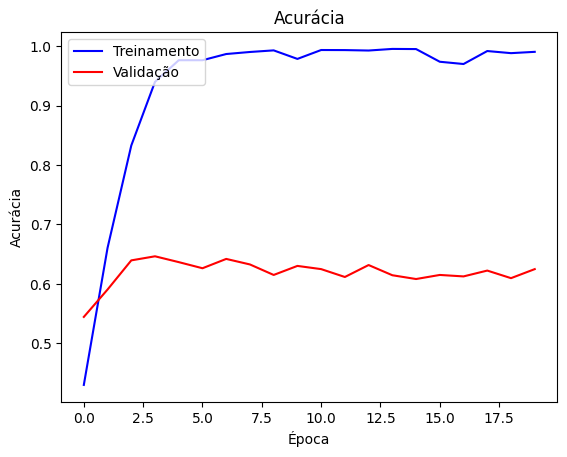

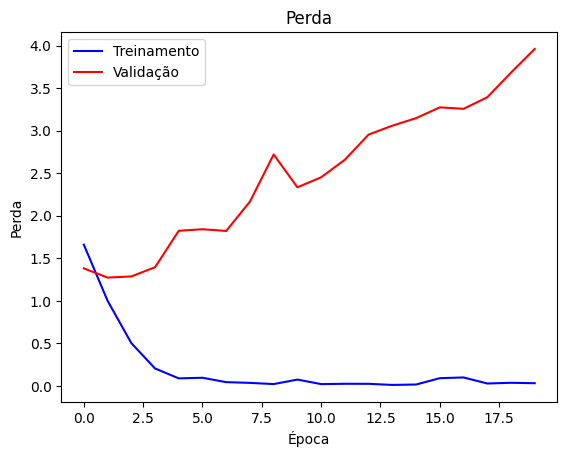

In [ ]:
historico = custom_treino_base.history
acuracia_treino = historico['accuracy']
epocas_treino = historico['val_accuracy']
acuracia_perda = historico['loss']
acuracia_epocas = historico['val_loss']
mostrar_resultado_modelo("Modelo Custom Base", acuracia_treino, epocas_treino, acuracia_perda, acuracia_epocas)

----------------------------RESULTADO-MODELOS----------------------------

--Modelo Custom Gradiente--

Acurácias durante o treinamento:
['13.89%', '19.59%', '25.39%', '29.43%', '31.13%', '32.56%', '34.20%', '35.74%', '36.67%', '37.62%', '38.83%', '40.02%', '40.93%', '41.87%', '43.26%', '44.02%', '44.67%', '45.72%', '45.66%', '46.89%']

Perdas durante o treinamento:
['2.26', '2.22', '2.17', '2.12', '2.07', '2.03', '1.98', '1.94', '1.91', '1.87', '1.84', '1.81', '1.78', '1.75', '1.73', '1.71', '1.69', '1.67', '1.65', '1.63']




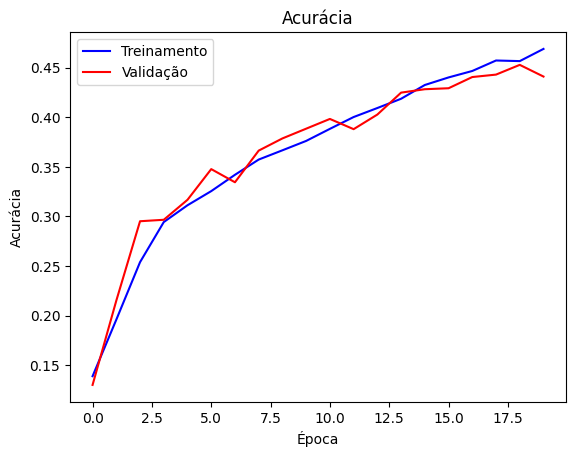

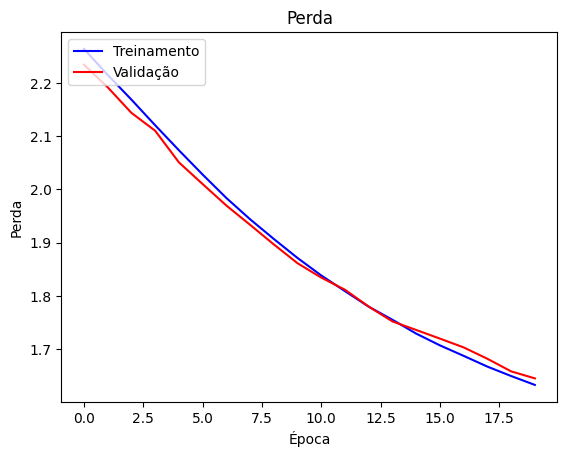

In [ ]:
historico = custom_treino_gradiente.history
acuracia_treino = historico['accuracy']
epocas_treino = historico['val_accuracy']
acuracia_perda = historico['loss']
acuracia_epocas = historico['val_loss']
mostrar_resultado_modelo("Modelo Custom Gradiente", acuracia_treino, epocas_treino, acuracia_perda, acuracia_epocas)

----------------------------RESULTADO-MODELOS----------------------------

--Modelo custom Adam--

Acurácias durante o treinamento:
['34.37%', '51.18%', '60.96%', '68.19%', '74.02%', '78.29%', '82.43%', '85.49%', '88.12%', '91.35%', '93.14%', '94.69%', '96.15%', '97.38%', '98.22%', '98.40%', '99.04%', '99.23%', '99.50%', '99.67%']

Perdas durante o treinamento:
['1.89', '1.44', '1.20', '1.02', '0.86', '0.74', '0.62', '0.52', '0.45', '0.36', '0.31', '0.26', '0.21', '0.17', '0.14', '0.12', '0.09', '0.08', '0.06', '0.05']




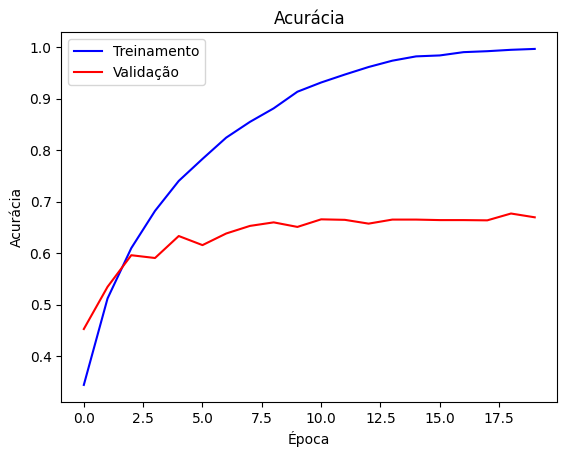

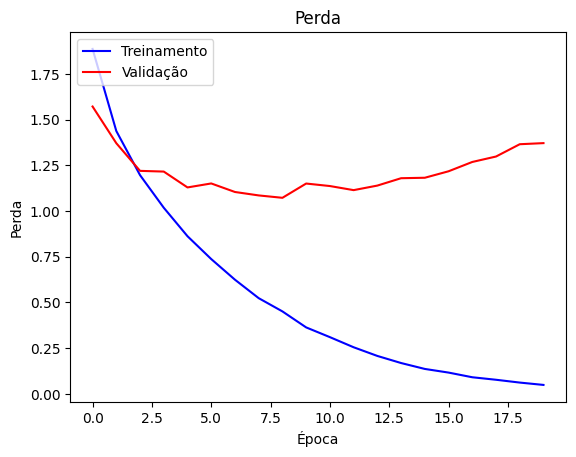

In [ ]:
historico = custom_treino_adam.history
acuracia_treino = historico['accuracy']
epocas_treino = historico['val_accuracy']
acuracia_perda = historico['loss']
acuracia_epocas = historico['val_loss']
mostrar_resultado_modelo("Modelo custom Adam", acuracia_treino, epocas_treino, acuracia_perda, acuracia_epocas)

In [ ]:
caminho_modelo = caminho_base + '/ModeloBaseCustom.h5'
classificador_custom_base.save(caminho_modelo)

In [ ]:
caminho_modelo = caminho_base + '/ModeloGradienteCustom.h5'
classificador_custom_gradiente.save(caminho_modelo)

In [ ]:
caminho_modelo = caminho_base + '/ModeloAdamCustom.h5'
classificador_custom_adam.save(caminho_modelo)